Mounted at /content/drive


In [ ]:
# pip install pandas

In [ ]:
# to call dara in
import os

# to manipulate datasets
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler


# to graph information
import seaborn as sns
import matplotlib.pyplot as plt

# to greate validation testing and training sets
from sklearn.model_selection import train_test_split
import random
from imblearn.under_sampling import RandomUnderSampler

# to gernerate statistcial information
from statistics import mean
from statistics import stdev
from statistics import median

# For the Models
from sklearn.neighbors import KNeighborsClassifier
import statistics 
from sklearn import metrics


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train_raw = pd.read_csv("ads_train.csv", sep=',')
test_raw = pd.read_csv("ads_test.csv", sep=',')

# Data Dictionary 
*   isbuyer - Past purchaser of product
*   buy_freq - How many times purchased in the past
      categorical variable
*   visit_freq - How many times visited website in the past
*   buy_interval - Average time between purchases
*   sv_interval - Average time between website visits
*   expected_time_buy – Expected Purchase time 
*   expected_time_visit – Expected access time 
*   last_buy - Days since last purchase.
*   last_visit - Days since last website visit.
*   multiple_buy – Whether the customer has purchased multiple times before. 
*   multiple_visit – Whether the customer has visited the site multiple times before. 
*   uniq_url - Number of unique urls we observed web browser on.
*   num_checkins - Number of times we observed web browser.
*   y_buy - Outcome variable of interest, did they purchase in period of interest.

# Data Handling

In [ ]:
# y_buy_1 = train['y_buy'] == 1
# train_buy = train[y_buy_1]

train = train_raw

train.buy_freq.fillna(0, inplace=True)

train["buy_freq"] = train["buy_freq"].astype("int")

train.isnull().sum()

train = train.rename(columns = {'Unnamed: 0': 'Buyer_ID'})



# EDA for Original Training Dataset

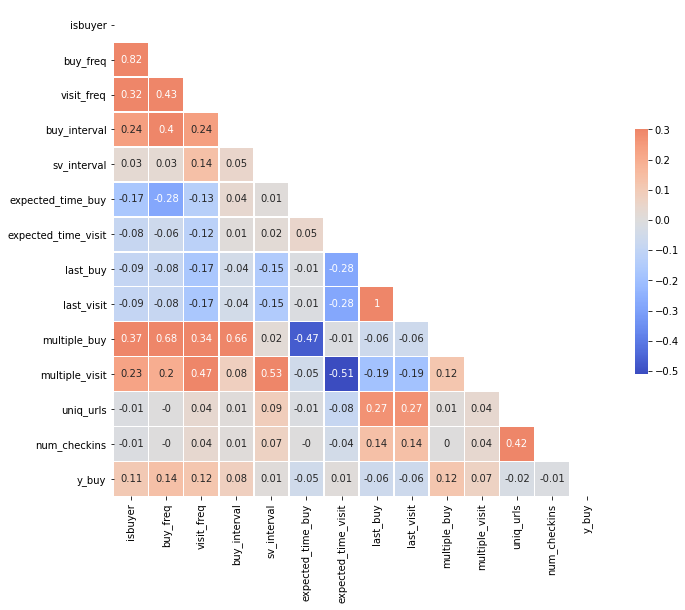

In [ ]:
# Compute the correlation matrix
corr = train_raw.drop(["Unnamed: 0"], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.round(2), 
            annot=True, mask=mask, 
            cmap=sns.color_palette("coolwarm", as_cmap=True), 
            vmax=.3, 
            center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})

## Initial findings
* positive correlation¶
  * lasy_visit and last_buy have a strong positive correlation (1.0)
  * multiple_buy has a strong correlation with buy_freq and buy_interval (0.68, 0.66).
  * multiple_visit has a moderate uphill linear relationship with visit_freq and sv_interval (0.47, 0.53)
  * num_checkins and uniq_urls (0.42)
* negative correlation
  * multiple_buy and expected_time_buy has a moderate downhill relationship (-0.47)
  * multiple_visit and expected_time_visit has a moderate downhill relationship (-0.51)

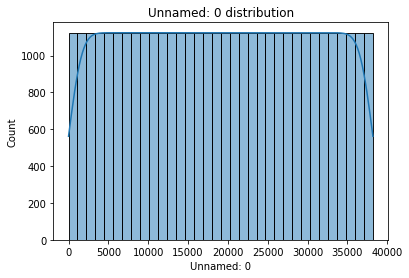

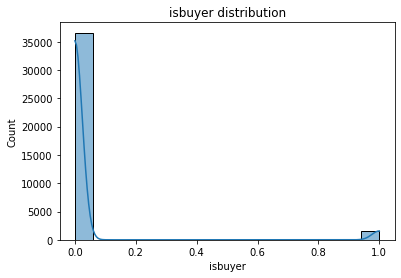

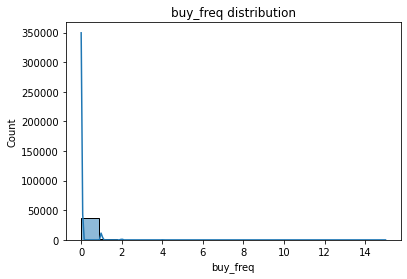

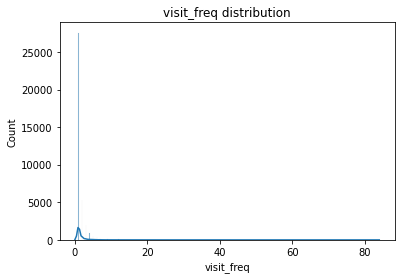

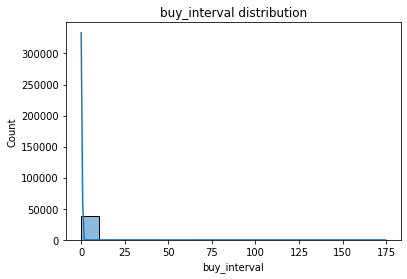

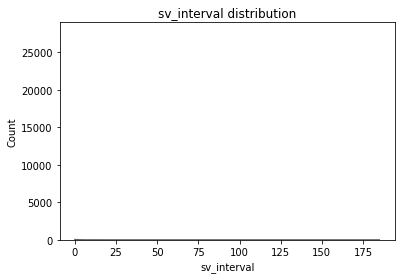

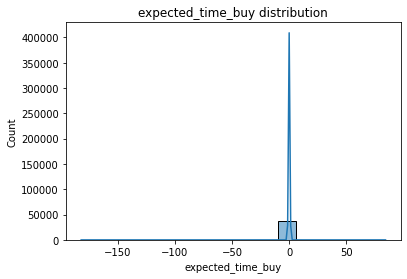

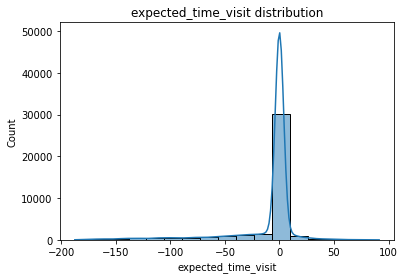

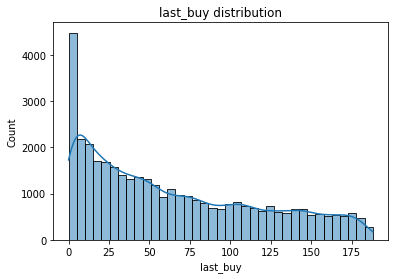

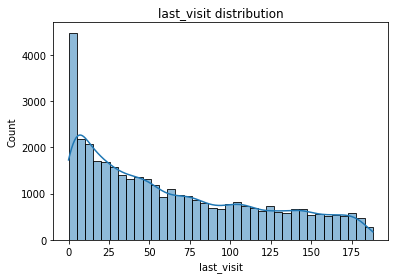

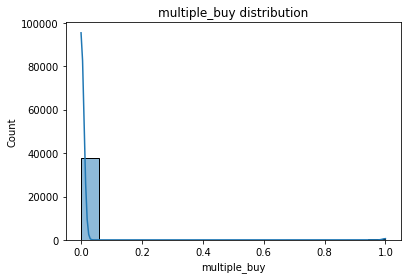

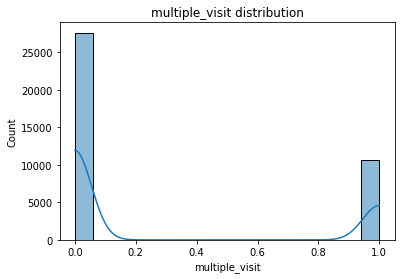

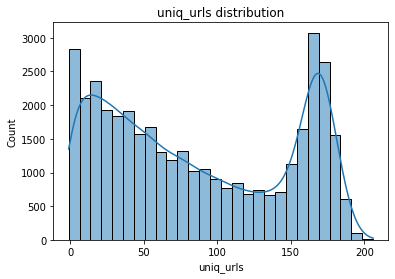

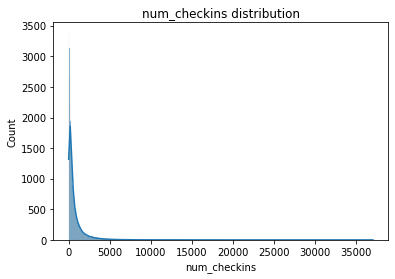

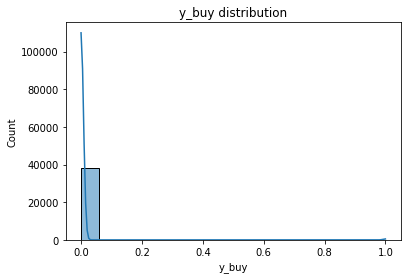

In [ ]:
# look at variable distribution
for x in train_raw:
  plt.figure()
  sns.histplot(data = train_raw, x = x, kde=True)
  plt.title(str(x + " distribution"))

## Dummies Creation

[Text(0, 0.5, 'Percentage of frequent visitors'),
 Text(0.5, 0, 'Number of times visited Amazon in the past')]

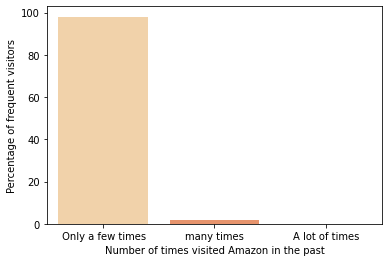

In [ ]:
#Spliting into categorical: visit frequent
train['visit_freq_dummies'] = np.where(train['visit_freq'] < 10, ' Only a few times',
                                           np.where(train['visit_freq'] < 40, 'many times', 'A lot of times'))

train['visit_freq_dummies'].value_counts()

#Visualize it:
ax =sns.barplot( x = 'visit_freq_dummies', y= 'y_buy', data = train, estimator=lambda x: len(x) / len(train) * 100,
                palette="OrRd")
ax.set(ylabel = 'Percentage of frequent visitors',
        xlabel = 'Number of times visited Amazon in the past')


In [ ]:
# print(train['visit_freq_dummies'].value_counts())
# print(pd.get_dummies(train["visit_freq_dummies"]).sum())

train[["visit_few_times", "visit_many_times"]] = pd.get_dummies(train["visit_freq_dummies"]).drop(['A lot of times'],axis = 1)


In [ ]:
## For is)_buyer:
#Plot the isbuyer for y_buy = 1: 
# ax =sns.barplot( x = 'isbuyer', y= 'isbuyer', data = train, estimator=lambda x: len(x) / len(train) * 100,
#                palette="OrRd")
# ax.set(ylabel = 'Percentage of is_buyer')

In [ ]:
## For buy_freq:
train['buy_freq_dummies'] = np.where(train['buy_freq'] < 1, 'Unknown', 
        np.where(train['buy_freq'] < 5 , 'Only a few times','Bought Alot'))

train['buy_freq_dummies'].value_counts()

# #plot:
#ax =sns.barplot( x = 'buy_freq_dummies', y= 'y_buy', data = train, estimator=lambda x: len(x) / len(train) * 100,
#                palette="OrRd")
#ax.set(ylabel = 'Percentage of frequent buyers',
#        xlabel = 'Number of times purchased from Amazon')

Unknown             36589
Only a few times     1597
Bought Alot            23
Name: buy_freq_dummies, dtype: int64

In [ ]:
# print(train['buy_freq_dummies'].value_counts())
# print(pd.get_dummies(train["buy_freq_dummies"]).sum())

# train[["a_lot", "many_time"]] = 
train[["buy_few_times", "buy_none"]] = pd.get_dummies(train["buy_freq_dummies"]).drop(["Bought Alot"], axis = 1)


In [ ]:
## For buy_interval:
## This is the time between purchases of a buyer, so the shorter the time, the more frequent that one bought an Item from Amazon. 
## So for the 0 time, would it be a daily buyers, or someone who just bought his/her first item on Amazon ?? Hmmmm 
## So I will split it into 4 categorical data:

train['buy_inter_dummies'] = np.where(train['buy_interval'] == 0, 'daily_or_new_buyers', 
                                      np.where(train['buy_interval'] < 5, 'frequent_buyers',
                                      np.where(train['buy_interval'] < 30, 'normal_buyers', 'occasion_buyers'))) 
train['buy_inter_dummies'].value_counts()

train[['daily_or_new_buyers','frequent_buyers','normal_buyers','occasion_buyers']] = pd.get_dummies(train["buy_inter_dummies"])

In [ ]:
## For sv_interval:
## Similar to buy_interval, but instead of buyers, let's change it into visitors:

train['sv_interval_dummies'] = np.where(train['sv_interval'] == 0, 'daily_or_new_visitors', 
                                      np.where(train['sv_interval'] < 5, 'frequent_visitors',
                                      np.where(train['sv_interval'] < 30, 'normal_visitors', 'occasion_visitors'))) 
train['sv_interval_dummies'].value_counts()

train[['daily_or_new_visitors','frequent_visitors','normal_visitors','occasion_visitors']] = pd.get_dummies(train["sv_interval_dummies"])



In [ ]:
## For expected_time_visit:
## I set negative time visit belongs to subcribers for a product. 
#plt.hist(train['expected_time_visit'], bins = 10)
#train['expected_time_visit'].value_counts()


train['expected_time_visit_dunmmies'] = np.where(train['expected_time_visit'] < 0, 'subcription_visit',
                                                 np.where(train['expected_time_visit'] == 0, 'none_time_visit', 'normal_time_visit'))
train['expected_time_visit_dunmmies'].value_counts()

train[['none_time_visit','normal_time_visit','subcription_visit']] = pd.get_dummies(train["expected_time_visit_dunmmies"])

In [ ]:
## For expected_time_buy:

#plt.hist(train['expected_time_buy'], bins = 10)
#print(train['expected_time_buy'].value_counts())
print('There are total of ' + str(train.shape[0]) + " records in this data file")

#Because there are only 228 records with value different from 0, so I will just go ahead and change them into 0
train['expected_time_buy'] = np.where(train['expected_time_buy'] == 0, '0', '0')

train['expected_time_buy'].value_counts()

There are total of 38209 records in this data file


0    38209
Name: expected_time_buy, dtype: int64

In [ ]:
## For last_visit:
## 0: just visit, 1-7: visit last week, 8-30: visit last month, 30-90: visit last 3 months, rest: visit long time ago
train['last_visit_dummies'] = np.where(train['last_visit'] == 0, 'just_visit',
                               np.where(train['last_visit'] <7 , 'visit_last_week',
                               np.where(train['last_visit'] < 30, 'visit_last_month',
                               np.where(train['last_visit'] < 90, 'visit_last_3_months', 'visit_long_time_ago'))))

train['last_visit_dummies'].value_counts()
#ax =sns.barplot( x = 'last_visit_dummies', y= 'y_buy', data = train, estimator=lambda x: len(x) / len(train) * 100, palette="OrRd")

train[['just_visit','visit_last_3_months','visit_last_month','visit_last_week','visit_long_time_ago']] = pd.get_dummies(train["last_visit_dummies"])
#train.drop(['visit_3_months'], axis = 1, inplace = True)



In [ ]:
## For last_buy:
## Following the same method as last_visit:
train['last_buy_dummies'] = np.where(train['last_buy'] == 0, 'just_bought',
                               np.where(train['last_buy'] <7 , 'bought_last_week',
                               np.where(train['last_buy'] < 30, 'bought_last_month',
                               np.where(train['last_buy'] < 90, 'bought_last_3_months', 'visit_long_time_ago'))))
train['last_buy_dummies'].value_counts()

train[['bought_last_3_months','bought_last_month','bought_last_week','just_bought','bought_long_time_ago']] = pd.get_dummies(train["last_buy_dummies"])

In [ ]:
## For uniq_url:
# For -1 and 0, there is no way a website doesnt have an URL while browsing. So I guess -1 and 0 belong to smart phone users
# There are a lot of user with over 50 tabs opening at once, so I guess they are merchandser
# The rest is regular users
train['uniq_urls_dummies']= np.where(train['uniq_urls'] < 1, 'smartphone_users',
                            np.where(train['uniq_urls'] < 50, 'merchandisers','regular_users'))
train['uniq_urls_dummies'].value_counts()

train[['merchandisers','regular_users','smartphone_users']] = pd.get_dummies(train["uniq_urls_dummies"])

In [ ]:
## For num_checking:

#print(train['num_checkins'].describe())
#print(train['num_checkins'].median())
#plt.hist(train['num_checkins'], bins = 3)

train['num_checkins_dummies'] = np.where(train['num_checkins'] < 130, 'light_checkins',
                                         np.where(train['num_checkins']< 800, 'normal_checkins','heavy_checkins'))
train['num_checkins_dummies'].value_counts()

train[['heavy_checkins','light_checkins','normal_checkins']] = pd.get_dummies(train["num_checkins_dummies"])

In [ ]:
train

,Buyer_ID,isbuyer,buy_freq,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy,visit_freq_dummies,visit_few_times,visit_many_times,buy_freq_dummies,buy_few_times,buy_none,buy_inter_dummies,daily_or_new_buyers,frequent_buyers,normal_buyers,occasion_buyers,sv_interval_dummies,daily_or_new_visitors,frequent_visitors,normal_visitors,occasion_visitors,expected_time_visit_dunmmies,none_time_visit,normal_time_visit,subcription_visit,last_visit_dummies,just_visit,visit_last_3_months,visit_last_month,visit_last_week,visit_long_time_ago,last_buy_dummies,bought_last_3_months,bought_last_month,bought_last_week,just_bought,bought_long_time_ago,uniq_urls_dummies,merchandisers,regular_users,smartphone_users,num_checkins_dummies,heavy_checkins,light_checkins,normal_checkins
0,1,0,0,1,0.0,0.000000,0,0.000000,106,106,0,0,169,2130,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,daily_or_new_visitors,1,0,0,0,none_time_visit,1,0,0,visit_long_time_ago,0,0,0,0,1,visit_long_time_ago,0,0,0,0,1,regular_users,0,1,0,heavy_checkins,1,0,0
1,2,0,0,1,0.0,0.000000,0,0.000000,6,6,0,0,150,539,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,daily_or_new_visitors,1,0,0,0,none_time_visit,1,0,0,visit_last_week,0,0,0,1,0,bought_last_week,0,0,1,0,0,regular_users,0,1,0,normal_checkins,0,0,1
2,3,0,0,2,0.0,0.500000,0,-101.149300,101,101,0,1,103,362,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,frequent_visitors,0,1,0,0,subcription_visit,0,0,1,visit_long_time_ago,0,0,0,0,1,visit_long_time_ago,0,0,0,0,1,regular_users,0,1,0,normal_checkins,0,0,1
3,4,0,0,1,0.0,0.000000,0,0.000000,42,42,0,0,17,35,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,daily_or_new_visitors,1,0,0,0,none_time_visit,1,0,0,visit_last_3_months,0,1,0,0,0,bought_last_3_months,1,0,0,0,0,merchandisers,1,0,0,light_checkins,0,1,0
4,5,0,0,3,0.0,45.479170,0,-34.144730,64,64,0,1,100,298,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,occasion_visitors,0,0,0,1,subcription_visit,0,0,1,visit_last_3_months,0,1,0,0,0,bought_last_3_months,1,0,0,0,0,regular_users,0,1,0,normal_checkins,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38204,38205,0,0,3,0.0,30.979170,0,12.621240,8,8,0,1,168,2080,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,occasion_visitors,0,0,0,1,normal_time_visit,0,1,0,visit_last_month,0,0,1,0,0,bought_last_month,0,1,0,0,0,regular_users,0,1,0,heavy_checkins,1,0,0
38205,38206,0,0,2,0.0,1.041667,0,-0.916713,1,1,0,1,1,15,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,frequent_visitors,0,1,0,0,subcription_visit,0,0,1,visit_last_week,0,0,0,1,0,bought_last_week,0,0,1,0,0,merchandisers,1,0,0,light_checkins,0,1,0
38206,38207,0,0,1,0.0,0.000000,0,0.000000,20,20,0,0,132,556,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,daily_or_new_visitors,1,0,0,0,none_time_visit,1,0,0,visit_last_month,0,0,1,0,0,bought_last_month,0,1,0,0,0,regular_users,0,1,0,normal_checkins,0,0,1
38207,38208,0,0,1,0.0,0.000000,0,0.000000,180,180,0,0,71,400,0,Only a few times,1,0,Unknown,0,1,daily_or_new_buyers,1,0,0,0,daily_or_new_visitors,1,0,0,0,none_time_visit,1,0,0,visit_long_time_ago,0,0,0,0,1,visit_long_time_ago,0,0,0,0,1,regular_users,0,1,0,normal_checkins,0,0,1


## EDA for Training Dataset - Customer Behavior

### Past Customer - is_buyer

In [ ]:
#filter the data to only records of people buying:
y_buy_1 = train['y_buy'] == 1
train_buy = train[y_buy_1]

#filter the data to only records of people not buying:
y_buy_0 = train['y_buy'] == 0
train_nbuy = train[y_buy_0]

#print out the group size
print("The total number of buyers in the train dataset is " + str(len(train_buy)) + ".")
print("The total number of non-buyers in the train dataset is " + str(len(train_nbuy)) + ".")


The total number of buyers in the train dataset is 172.
The total number of non-buyers in the train dataset is 38037.


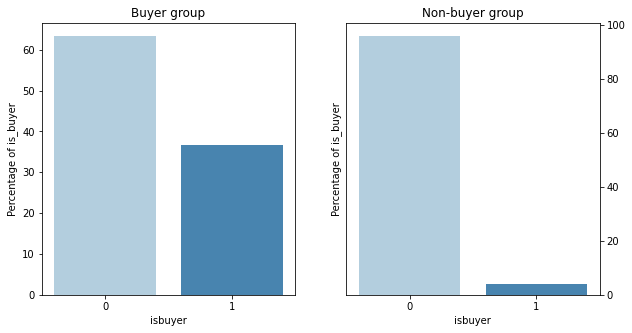

In [ ]:
from matplotlib import gridspec

# for is_buyer
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='isbuyer', y='isbuyer', data = train_buy, estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Buyer group',
     ylabel = 'Percentage of is_buyer')

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'isbuyer', y= 'isbuyer', data = train_nbuy, estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of is_buyer')
ax2.yaxis.tick_right()

plt.show()

The percentage of purchases made in non-buyer group is less than 5%, comparing to the buyer group close to 40%. Looking at the sample, past buyers are more likely to make purchase compared to who wasn't a buyer on Amazon. 
* Buz insights/ possible recommendation - focus more on customer acquisition from leads/qualified to new customers (put acquisition funnel pic)

### Buy frquency - buy_freq

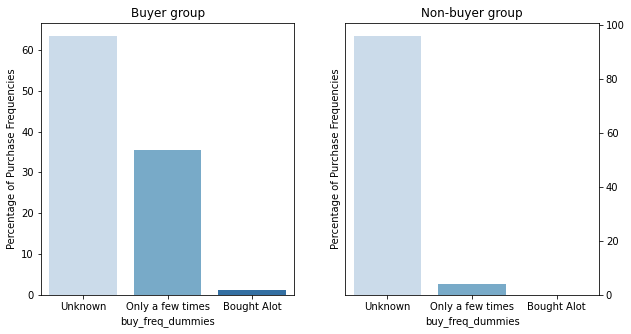

In [ ]:
# for buy_freq
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='buy_freq_dummies', y='buy_freq', data = train_buy.sort_values(by='buy_freq_dummies', ascending=False), estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Buyer group',
     ylabel = 'Percentage of Purchase Frequencies')

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'buy_freq_dummies', y= 'buy_freq', data = train_nbuy.sort_values(by='buy_freq_dummies', ascending=False), estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of Purchase Frequencies')
ax2.yaxis.tick_right()

plt.show()

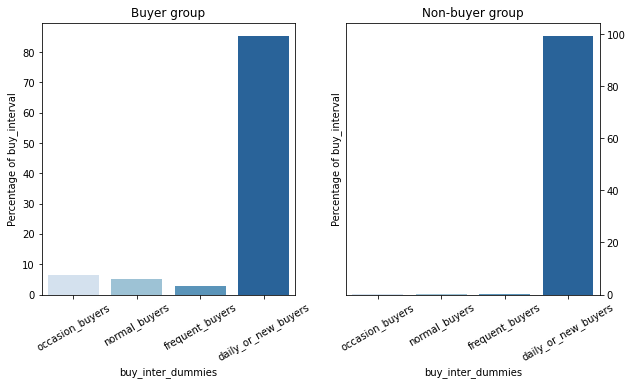

In [ ]:
# for buy_interval
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='buy_inter_dummies', y='buy_interval', data = train_buy.sort_values(by='buy_inter_dummies', ascending=False), estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Buyer group',
     ylabel = 'Percentage of buy_interval')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'buy_inter_dummies', y= 'buy_interval', data = train_nbuy.sort_values(by='buy_inter_dummies', ascending=False), estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of buy_interval')
ax2.yaxis.tick_right()
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)

plt.show()

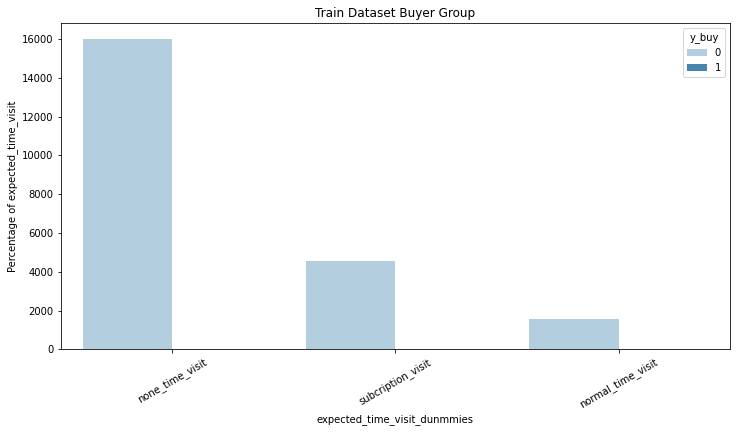

In [ ]:
## For expected_time_visit:
## I set negative time visit belongs to subcribers for a product. 
# expected_time_visit_dunmmies
fig = plt.figure(figsize=(12, 6))
# gs = gridspec.GridSpec(nrows=1, ncols=2,
#                        height_ratios=[6], 
#                        width_ratios=[10, 10]) #width of two charts


ax1 = sns.barplot(x='expected_time_visit_dunmmies', y='expected_time_visit',  hue="y_buy", data = train, estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Train Dataset Buyer Group',
     ylabel = 'Percentage of expected_time_visit')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)
# ax2 = plt.subplot(gs[1])
# sns.barplot(x = 'expected_time_visit_dunmmies', y= 'expected_time_visit', data = train_nbuy, estimator=lambda x: len(x) / len(train_nbuy) * 100,
#                palette="Blues")
# ax2.set(title = 'Train Dataset Non-buyer Group',
#      ylabel = 'Percentage of expected_time_visit')
# ax2.yaxis.tick_right()
# ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)
plt.show()

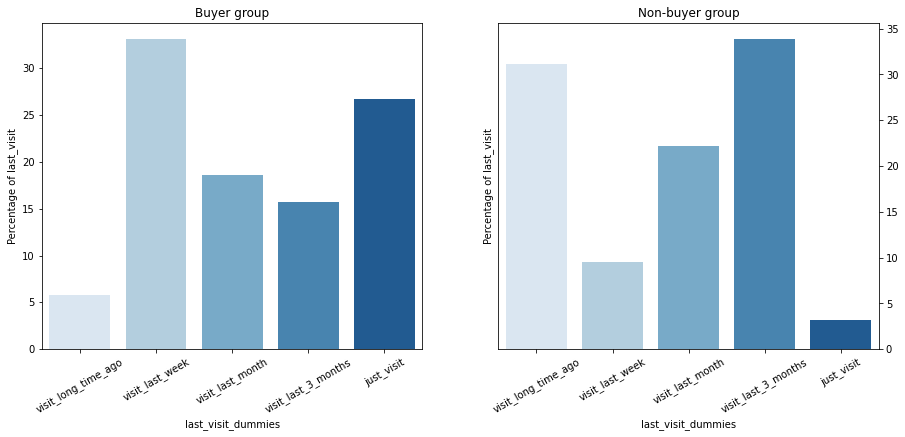

In [ ]:
# For last_visit:
fig = plt.figure(figsize=(15, 6))
# gs = gridspec.GridSpec(nrows=1, ncols=2,
#                        height_ratios=[6], 
#                        width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='last_visit_dummies', y='last_visit', data = train_buy.sort_values(by='last_visit_dummies', ascending=False), estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Buyer group',
     ylabel = 'Percentage of last_visit')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'last_visit_dummies', y= 'last_visit', data = train_nbuy.sort_values(by='last_visit_dummies', ascending=False), estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of last_visit')
ax2.yaxis.tick_right()
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)

plt.show()

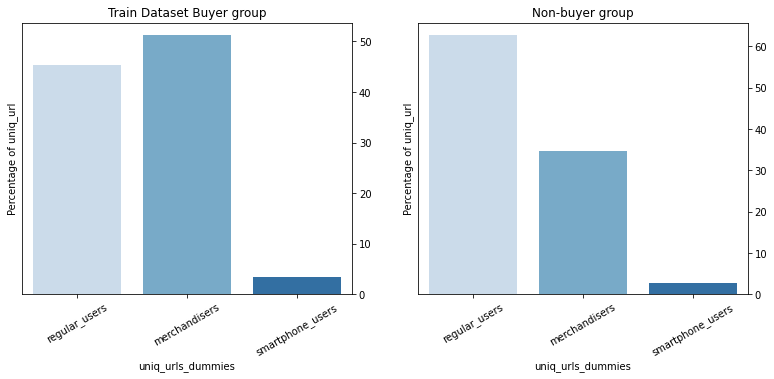

In [ ]:
# For uniq_url:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='uniq_urls_dummies', y='uniq_urls', data = train_buy, estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Train Dataset Buyer group',
     ylabel = 'Percentage of uniq_url')
ax1.yaxis.tick_right()
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'uniq_urls_dummies', y= 'uniq_urls', data = train_nbuy, estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of uniq_url')
ax2.yaxis.tick_right()
ax2.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

plt.show()

# in one graph
# ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
# sns.barplot(x='uniq_urls_dummies', y='uniq_urls', hue="y_buy", data = train, estimator=lambda x: len(x) / len(train) * 100,
#                palette="Blues") 
# ax1.set(title = 'Buyer group',
#      ylabel = 'Percentage of buy_interval')
# ax1.yaxis.tick_right()
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)

* Category definition: For -1 and 0, there is no way a website doesnt have an URL while browsing. So I guess -1 and 0 belong to smart phone user. There are a lot of user with over 50 tabs opening at once, so I guess they are merchandser
* Findings: 

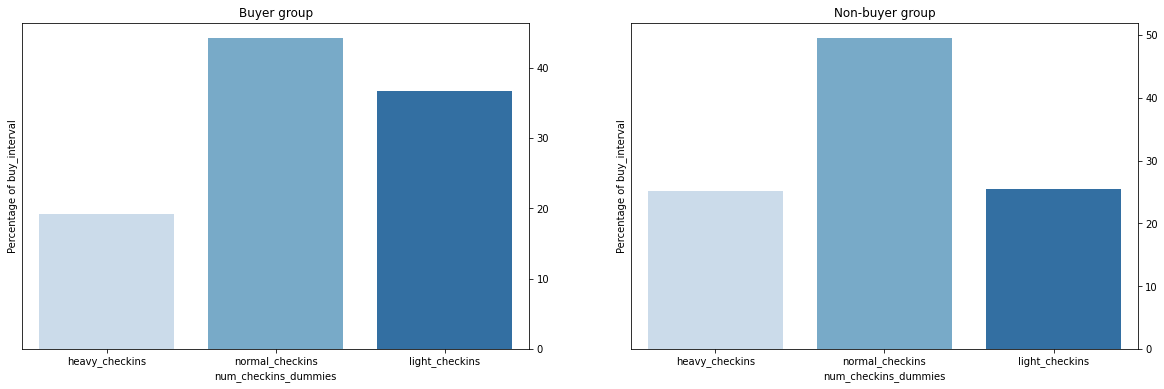

In [ ]:
# For num_checking:
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 10]) #width of two charts


ax1 = plt.subplot(gs[0]) # put this chart in 2nd place.
sns.barplot(x='num_checkins_dummies', y='num_checkins', data = train_buy, estimator=lambda x: len(x) / len(train_buy) * 100,
               palette="Blues") 
ax1.set(title = 'Buyer group',
     ylabel = 'Percentage of buy_interval')
ax1.yaxis.tick_right()

ax2 = plt.subplot(gs[1])
sns.barplot(x = 'num_checkins_dummies', y= 'num_checkins', data = train_nbuy, estimator=lambda x: len(x) / len(train_nbuy) * 100,
               palette="Blues")
ax2.set(title = 'Non-buyer group',
     ylabel = 'Percentage of buy_interval')
ax2.yaxis.tick_right()

plt.show()

## Dropping Columns 

* Columns with high colinarity
  * last_visit
  * multiple_visit

* columns dummies are derived from
  * buy_freq
  * visit_freq



In [ ]:
train.drop(["buy_freq", "visit_freq", "buy_interval","sv_interval", "expected_time_visit", "last_buy","last_visit","multiple_buy",
                    "multiple_visit","uniq_urls","num_checkins","visit_freq_dummies", "buy_freq_dummies", "buy_inter_dummies",
                    "sv_interval_dummies", "expected_time_visit_dunmmies","last_visit_dummies", "last_buy_dummies","uniq_urls_dummies","num_checkins_dummies" ], axis = 1, inplace = True)

#train = train[['Buyer_ID', 'isbuyer', 'buy_a_lot',	'buy_a_few', 'visit_a_lot', 'visit_many_time', 'buy_interval', 'sv_interval', 'expected_time_buy', 'expected_time_visit', 'last_buy', 
#                'uniq_urls','num_checkins', 'y_buy']]

In [ ]:
train

,Buyer_ID,isbuyer,expected_time_buy,y_buy,visit_few_times,visit_many_times,buy_few_times,buy_none,daily_or_new_buyers,frequent_buyers,normal_buyers,occasion_buyers,daily_or_new_visitors,frequent_visitors,normal_visitors,occasion_visitors,none_time_visit,normal_time_visit,subcription_visit,just_visit,visit_last_3_months,visit_last_month,visit_last_week,visit_long_time_ago,bought_last_3_months,bought_last_month,bought_last_week,just_bought,bought_long_time_ago,merchandisers,regular_users,smartphone_users,heavy_checkins,light_checkins,normal_checkins
0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
1,2,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
2,3,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1
3,4,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,5,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38204,38205,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
38205,38206,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
38206,38207,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
38207,38208,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1


## Undersampling

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.5)

cols = train.columns.tolist()
cols = [c for c in cols if c not in ["y_buy"]]

target = "y_buy"

#define X and Y
X = train[cols]
Y = train[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Y_under = pd.DataFrame(Y_under, columns = ['y_buy'])
Y_under.shape

(516, 1)

In [ ]:
# pd.DataFrame(X_under).shape == pd.DataFrame(data = X_under, columns = train.drop(["y_buy"], axis = 1).columns.tolist()).shape

X_under = pd.DataFrame(data = X_under, columns = train.drop(["y_buy"], axis = 1).columns.tolist())
X_under.shape

(516, 34)

## Splitting 

In [ ]:
under_merged = pd.concat([Y_under, X_under], axis = 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.25, random_state=12345)

In [ ]:
print("the shape of X_train: " + str(x_train.shape))
print("the shape of Y_train: " + str(y_train.shape))
print("the shape of x_test: " + str(x_test.shape))
print("the shape of y_test: " + str(y_test.shape))

the shape of X_train: (387, 34)
the shape of Y_train: (387, 1)
the shape of x_test: (129, 34)
the shape of y_test: (129, 1)


In [ ]:
#train_under, test_under = train_test_split(under_merged, test_size=0.25, random_state=12345)

#print("shape of train_under" + str(train_under.shape))
#print("shape of test_under" + str(test_under.shape))

#print(train_under.columns)
#print(test_under.columns)

In [ ]:
#x_train = train_under.drop(['y_buy', 'Buyer_ID'], axis = 1)
#x_test = test_under.drop(['y_buy', 'Buyer_ID'], axis = 1)
#y_train = train_under["y_buy"]
#y_test = test_under["y_buy"]

#print("the shape of X_train: " + str(x_train.shape))
#print("the shape of Y_train: " + str(y_train.shape))
#print("the shape of x_test: " + str(x_test.shape))
#print("the shape of y_test: " + str(y_test.shape))
#print(x_train.columns)
#print(x_test.columns)

## Exporting Data for Modeling

In [ ]:
print(os.getcwd())
os.chdir("/content/drive/My Drive/Boardroom_Group_5/")
# print("new directory " + str(os.getcwd()))

/content


In [ ]:
# train_under[['Buyer_ID', 'isbuyer', 'buy_a_lot', 'buy_a_few', 'visit_a_lot',
#        'visit_many_time', 'buy_interval', 'sv_interval', 'expected_time_buy',
#        'expected_time_visit', 'last_buy', 'uniq_urls', 'num_checkins', 'y_buy']].to_csv("validation_train.csv", index = False)

In [ ]:
x_train.to_csv("x_train_cat.csv", index = False)
x_test.to_csv("x_test_cat.csv", index = False)
y_train.to_csv("y_train_cat.csv", index = False)
y_test.to_csv("y_test_cat.csv", index = False)

In [ ]:

## Export the original categorical Train Data without undersampling:
#train.drop(['Buyer_ID'], axis = 1, inplace = True)
train.to_csv('train_categorical_no_undersample.csv', index = False)